<figure>
  <IMG SRC="https://raw.githubusercontent.com/mbakker7/exploratory_computing_with_python/master/tudelft_logo.png" WIDTH=250 ALIGN="right">
</figure>

## Likelihood-based calibration of hydrological models

*ENVM1502* - March 2025

### Introduction

This notebook discusses the likelihood-based approach of calibrating hydrological models. This approach provides an alternative to the use of goodness-of-fit calibration criteria such as the Nash-Sutcliffe Efficiency (NSE) and allows for systematically identifying an appropriate objective function for calibration, by linking the objective function, i.e. the likelihood, to the underlying statistical assumptions it is based on. 

An attractive feature of this approach is that it follows the scientific cycle of (i) building a model, (ii) checking performance of the model against data, and (iii) going back to step 1 to revise initial assumptions in the model. We simply extend the notion of our "model" to not only denote the hydrological model itself but also any other (probabilistic) assumptions we make about the data. As a bonus, we get estimates of uncertainty in the model predictions for free. It can be argued that this is in fact an essential feature, i.e. that you should never provide deterministic model predictions. 

The approach will be explored using the data and the HBV model from a previous modeling exercise.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from HBVMod import HBVMod#the rainfall-runoff model
from scipy.optimize import differential_evolution#the calibration algorithm
from scipy.stats import norm#the normal distribution
import pandas as pd

### Load the data 

Read in daily time-series of precipitation (P), potential evaporation (Ep), and observed runoff (Qobs). All in mm/day.

In [31]:
import xarray as xr
import pandas as pd
import numpy as np

# --- 1. Load Precipitation Data (NetCDF) ---
def load_precipitation(filepath):
    ds = xr.open_dataset(filepath)
    df = ds.to_dataframe().reset_index()
    df = df[df['bnds'] == 0]  # Filter to keep valid bounds
    df.index = pd.to_datetime(df['time'])
    df.index = df.index.normalize()  # Set index to Timestamp (no time component)
    df = df.drop(columns=['time', 'bnds'])
    prec = df['pr'] * 86400  # Convert from m/s to mm/day
    prec[prec < 0] = np.nan  # Handle negative values
    return prec.dropna()

prec = load_precipitation("OBS6_ERA5_reanaly_1_day_pr_2000-2018.nc")

# --- 2. Load Potential Evapotranspiration (NetCDF) ---
def load_evapotranspiration(filepath):
    ds = xr.open_dataset(filepath)
    df = ds.to_dataframe().reset_index()
    df.index = pd.to_datetime(df['time'])
    df.index = df.index.normalize()
    ep = df['evspsblpot'] * 86400  # Convert from mm/s to mm/day
    ep[ep < 0] = np.nan
    return ep.dropna()

EP = load_evapotranspiration("Derived_Makkink_evspsblpot_2000_2018.nc")

# --- 3. Load Discharge Data (CSV) ---
def load_discharge(filepath, basin_area):
    df = pd.read_csv(filepath, delimiter=";", skiprows=37, header=None, encoding='latin1')
    df = df[[0, 2]]  # Keep only date and Q columns
    df.columns = ['Date', 'Q']
    df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
    df.set_index('Date', inplace=True)
    df['Q'] = (df['Q'] / basin_area) * 1e3 * 86400  # Convert to mm/day
    df['Q'][df['Q'] < 0] = np.nan
    return df['Q'].dropna()

A = 21497e6  # Basin area in m²
dfQ = load_discharge("6227510_Q_Day.Cmd.txt", A)

# --- 4. Align Time Series (2000-2017) ---
def align_data(prec, EP, Q, start_year=2000, end_date='2017-09-30'):
    # Filter by date range
    prec = prec[(prec.index.year >= start_year) & (prec.index <= pd.to_datetime(end_date))]
    EP = EP[(EP.index.year >= start_year) & (EP.index <= pd.to_datetime(end_date))]
    Q = Q[(Q.index.year >= start_year) & (Q.index <= pd.to_datetime(end_date))]
    # Merge into a single DataFrame
    aligned_data = pd.concat([prec, EP, Q], axis=1, join='inner')
    aligned_data.columns = ['prec', 'EP', 'Q']
    return aligned_data

final_data = align_data(prec, EP, dfQ)
# Drop rows where any column has a NaN value
final_data = final_data.dropna()
print(final_data.head())


                prec        EP         Q
2000-01-01  0.004016  1.168847  0.034243
2000-01-02  0.000000  1.184061  0.034726
2000-01-03  0.020909  1.059634  0.034927
2000-01-04  0.000000  1.175390  0.034525
2000-01-05  0.000000  1.182336  0.035047


C:\Users\margh\AppData\Local\Temp\ipykernel_77604\769257442.py:39: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['Q'][df['Q'] < 0] = np.nan


In [32]:
forcing = np.genfromtxt('Forcing.txt', dtype=float, autostrip=True)
forcing = forcing[:,3:6]
P = final_data['prec'].values
Ep = final_data['EP'].values
Qobs = final_data['Q'].values


### Set up and run the model 

We use the HBV model, as implemented in HBVMod.py. This file defines a method HBVMod that takes 4 input arguments: (i) an array of 8 hydrological parameters, (ii) time-series of daily precipitation (mm/day), (iii) time-series of daily potential evaporation (mm/day), and (iv) a 4-element array of initial storage values (mm). The method returns a time-series of simulated daily runoff (mm/day).

In [33]:
#          Imax    Ce        Sumax      beta      Pmax          Tlag     Kf           Ks
bounds = [(0, 8), (0.2, 1), (40, 800), (0.5, 4), (0.001, 0.3), (0, 10), (0.01, 0.1), (0.0001, 0.01)]

# Function that takes in a parameter vector, runs the model, and returns the time-series of simulated runoff
def run_model(par):
    Sin = np.array([0,  100,  0,  5.0])#initial storages
    return HBVMod(par, P, Ep, Sin)

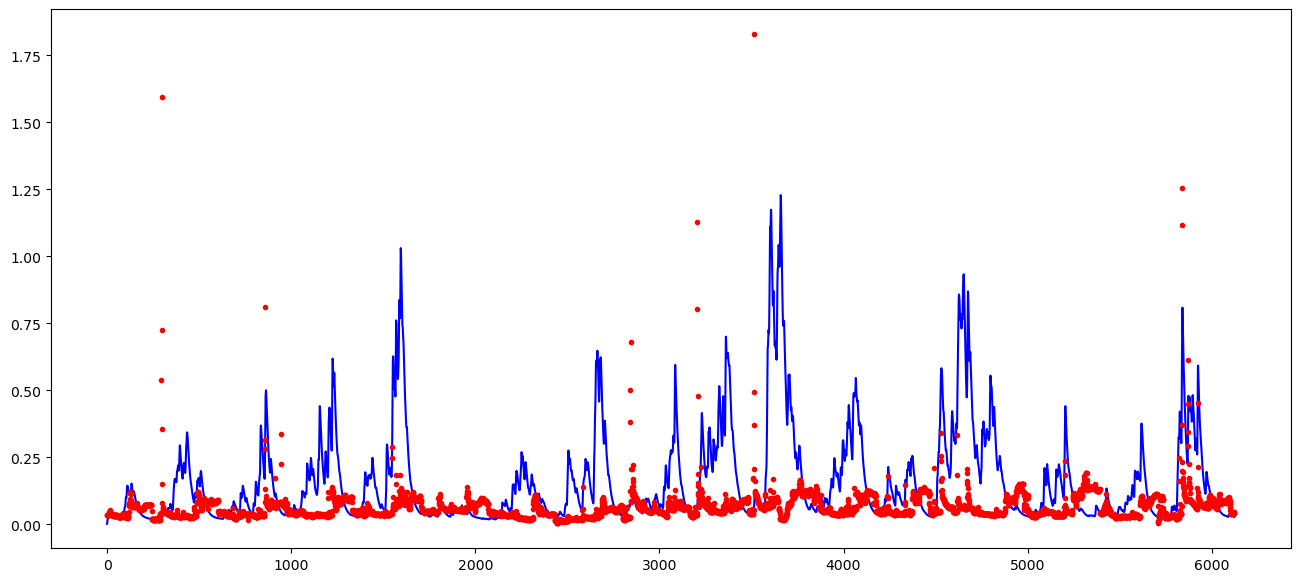

In [34]:
# Quick test to make sure the model runs
par = np.array([4, 0.6, 400, 2, 0.1, 5, 0.05, 0.005])#some arbitrary parameter values
Qsim = run_model(par)
plt.figure(figsize=(16,7))
plt.plot(Qsim, 'b')
plt.plot(Qobs, 'r.')
plt.show()

### Model calibration using NSE

Before moving to likelihood-based calibration, we first create a reference solution by calibrating the model using the popular [Nash-Sutcliffe Efficiency or NSE](https://en.wikipedia.org/wiki/Nash%E2%80%93Sutcliffe_model_efficiency_coefficient) as objective function. This repeats what you did before, except that here we use an optimization algorithm. The following three steps always come back: a. implement the objective function, b. run the calibration, c. plot the results.

#### a. Implement the objective function
The function below takes in a parameter set, runs the model, and computes the *negative* NSE. The reason for computing the negative NSE is that the optimization algorithm will try to minimize our objective function.

In [35]:
def neg_NSE(par):
    Qsim = run_model(par)
    sim = Qsim[365:]#exclude first year as warm-up
    obs = Qobs[365:]
    NSE = 1 - np.sum((obs-sim)**2) / np.sum((obs-np.mean(obs))**2)
    return -NSE#return the negative NSE, since we're going to minimize

#### b. Run the calibration
We use the [differential evolution](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html#scipy.optimize.differential_evolution) algorithm, available as python function `differential_evolution` imported at the start of this notebook. This is a *global* optimization algorithm suitable for calibration of rainfall-runoff models, as it avoids getting stuck in local minima of the objective function. The differential evolution algorithm requires two inputs, namely the objective function to be minimized (in our case, negative NSE) and bounds for the model parameters.

In [36]:
# Use differential evolution to minimize the objective function (neg_NSE) by varying the model parameters within the bounds
result = differential_evolution(neg_NSE, bounds)#runs the calibration
par = result.x#grabs the best parameter set
NSE = -neg_NSE(par)#computes NSE for the best parameter set
print(par, NSE)
#print(f"Calibrated Parameters: {par}")

[0.00000000e+00 3.96260689e-01 7.99647997e+02 4.00000000e+00
 3.00000000e-01 1.17999818e+00 1.00000000e-02 2.23672605e-03] 0.021494998251582076


#### c. Plot the results
Run the model with the calibrated parameter set and plot the resulting time-series of simulated discharge together with the observed discharge.

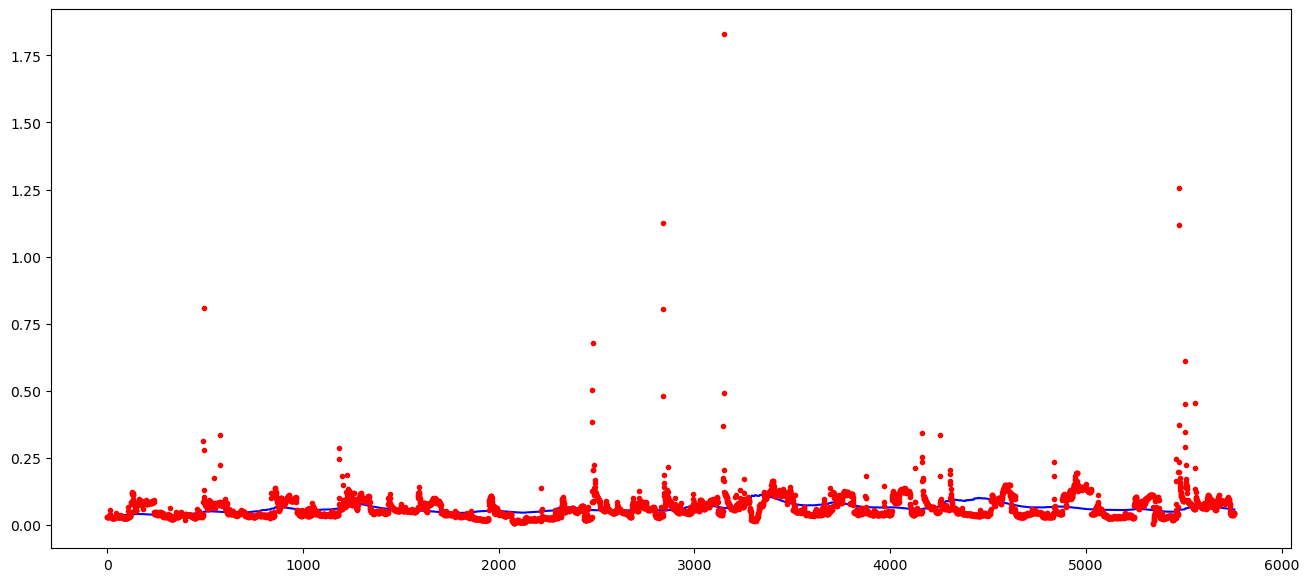

In [37]:
Qsim = run_model(par)
plt.figure(figsize=(16,7))
plt.plot(Qsim[365:], 'b')
plt.plot(Qobs[365:], 'r.')
plt.show()

### Likelihood-based calibration

Likelihood-based calibration relies on an assumed probabilistic observation model for the relation between simulated and observed runoff. This assumed observation model leads to a corresponding likelihood function, which is used as objective function for calibration (maximum likelihood). After calibration, we check the assumed observation model by computing prediction intervals: do they adequately capture the data (not too wide, not too narrow)? If not, we should revise assumptions in the observation model.

We will compare two observation models: normal and lognormal.

### Normal observation model
Refer to the lecture slides for formulas of the normal observation model. Use these to implement the likelihood function, run the calibration, and plot the results. Your results should reveal the following findings:

* the normal observation model is equivalent to the NSE criterion, in the sense that you get very similar parameter estimates when maximizing NSE vs maximizing the likelihood function of the normal observation model.

* the normal observation model does not lead to good prediction intervals for all flows - a good prediction interval being one that is neither too wide (does not extend far beyond the data) or too narrow (does not exclude many data points)

#### a. Implement the objective function
Implement a function that takes in an array with nine parameters (the eight hydrological model parameters and the $\sigma$ parameter of the normal observation model), and returns the negative log-likelihood averaged over all time steps (excluding warm-up).

*Hint: use the `norm.logpdf` function to directly compute the normal log-density. This is numerically more stable (and more efficient) than first computing `norm.pdf` followed by `np.log`.*

In [38]:
# Negative log-likelihood function for normal observation model
def neg_loglik_norm(par):
    Qsim = run_model(par[:-1])#the last parameter is sigma; exclude it when running the model
    sigma = par[-1]
    
    ### ADD CODE HERE THAT COMPUTES logL
    
    logL = np.sum(norm.logpdf(Qobs[365:],loc = Qsim[365:], scale = sigma))

    return -logL

#### b. Run the calibration
Calibrate the model by minimizing the negative log-likelihood function. Report the maximum log-likelihood value and compare the calibrated parameter values to those obtained when maximizing NSE. How large is the estimated standard deviation $\sigma$?

In [39]:
bounds.append((0, 1)) #add min-max bounds for sigma
result = differential_evolution(neg_loglik_norm, bounds)
par = result.x
maxloglik = -neg_loglik_norm(par)
print(maxloglik, par)

c:\Users\margh\anaconda3\envs\mude-base\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2029: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


8718.450297366024 [3.50182269e-01 3.95981972e-01 7.81686432e+02 3.75937719e+00
 2.92256700e-01 6.38963717e+00 1.10497734e-02 2.46819562e-03
 5.35375047e-02]


#### c. Plot the results
Make a time-series plot that includes observed runoff and 90% prediction intervals of runoff simulated with the calibrated model:
* compute 90% prediction intervals by calculating 5% and 95% quantiles at each time step - see the `norm.ppf` function;
* plot the prediction intervals using the `fill_between` function in `matplotlib`

Do you notice any issues with the prediction intervals?

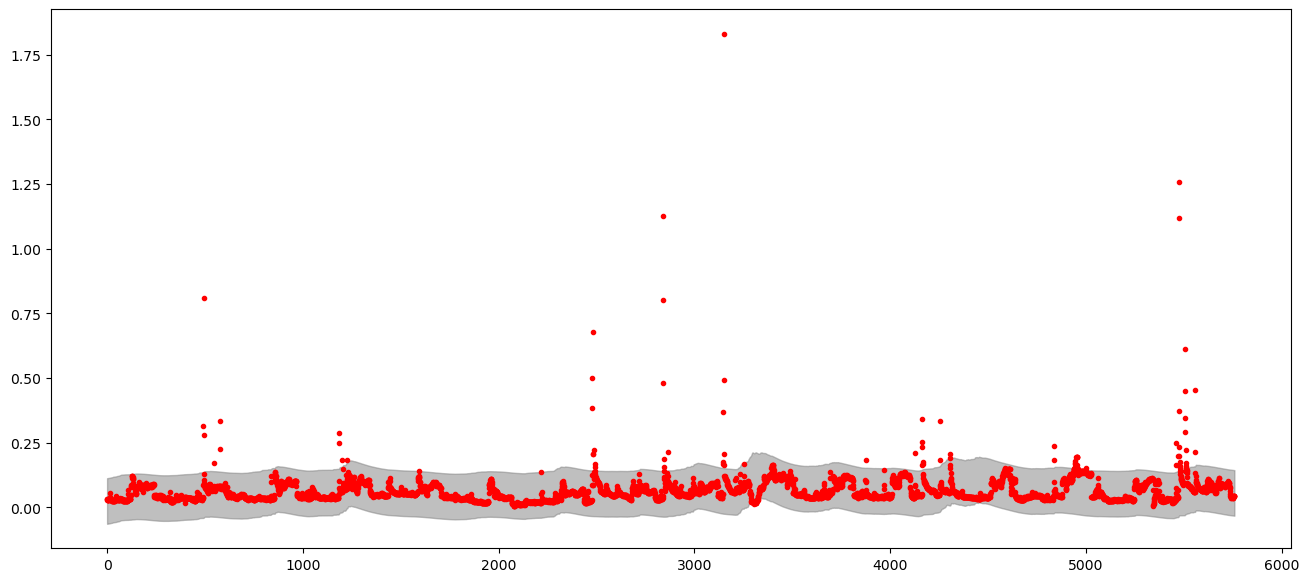

In [40]:
### ADD CODE HERE THAT RUNS THE CALIBRATED MODEL AND COMPUTES TIME-SERIES OF 5% AND 95% QUANTILES (Q05 and Q95)

Q05 = norm.ppf(0.05, loc = run_model(par[:-1])[365:], scale = par[-1])
Q95 = norm.ppf(0.95, loc = run_model(par[:-1])[365:], scale = par[-1])

# Plot the 90% prediction intervals and the data
plt.figure(figsize=(16,7))
plt.fill_between(np.arange(len(Q05)), Q05, Q95, color='grey', alpha=0.5)
plt.plot(Qobs[365:], 'r.')
plt.show()

### Lognormal observation model

The normal observation model makes at least two unrealistic assumptions: (i) observed runoff has a normal distribution, and (ii) the standard deviation is the same for high and low flows. The first assumption can be problematic for low flows, where a normal distribution can easily lead to prediction intervals that give negative flows. To remedy this, we will instead assume that observed runoff has a [lognormal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution), which a priori excludes any negative values. The second assumption will be revised by assuming that the *relative* instead of *absolute* standard deviation is constant. The relative standard deviation is the standard deviation divided by the mean; it is also known as the coefficient of variation. A constant coefficient of variation implies an increase in the (absolute) standard deviation as flow increases. This captures the often larger model and data errors that occur at higher flows. For example, "observed" flow is actually computed from a rating curve that typically becomes less reliable at high flows.

See lecture slides for formulas.

#### a. Implement the objective function
Implement a function that takes in an array with nine parameters (the eight hydrological model parameters and the $CV$ parameter of the lognormal observation model), and returns the negative log-likelihood averaged over all time steps (excluding warm-up).

In [41]:
# Negative log-likelihood function for lognormal observation model
def neg_loglik_lognorm(par):
    
    ### ADD CODE HERE THAT RUNS THE HBV MODEL AND COMPUTES logL
    Qsim = run_model(par[:-1])
    sigmat = np.sqrt(np.log(par[-1]**2+1))
    mut =  np.log(Qsim) + sigmat**2
    xt = np.log(Qobs)

    
    logL = np.sum(norm.logpdf(xt[365:],loc = mut[365:], scale = sigmat)-np.log(Qobs[365:]))
 
    return -logL

#### b. Run the calibration
Calibrate the model by minimizing the negative log-likelihood function. Compare the results to the results for the normal observation model in terms of maximum log-likelihood value and calibrated parameter values. What is the estimated coefficient of variation?

In [42]:
result = differential_evolution(neg_loglik_lognorm, bounds)
par = result.x
maxloglik = -neg_loglik_lognorm(par)
print(maxloglik, par)

12378.422120330206 [8.39890228e-01 2.74742116e-01 7.49468359e+02 3.64632866e+00
 2.76935789e-01 6.59873828e+00 1.13111790e-02 2.08787136e-03
 5.70540679e-01]


#### c. Plot the results
Make a time-series plot that includes observed runoff and 90% prediction intervals of runoff simulated with the calibrated model. Did the prediction intervals improve compared to the normal observation model?

*Hint: quantiles of the lognormal distribution are obtained by exponentiating quantiles of the underlying normal distribution* 

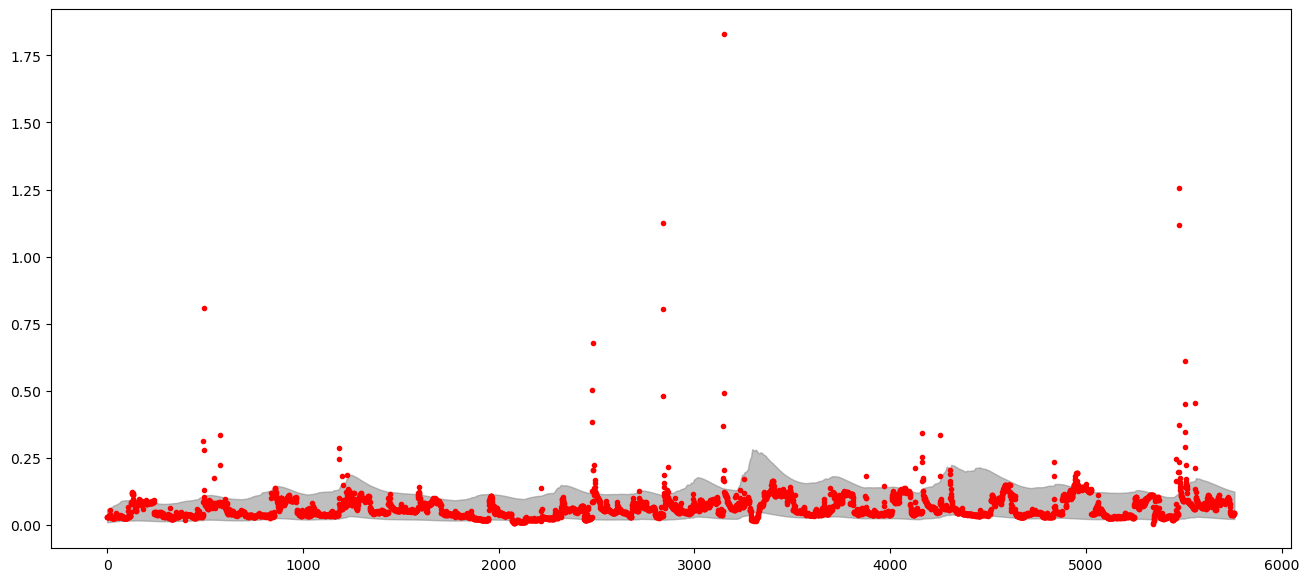

In [43]:
### ADD CODE HERE THAT RUNS THE CALIBRATED MODEL AND COMPUTES TIME-SERIES OF 5% AND 95% QUANTILES (Q05 and Q95)
Qsim = run_model(par[:-1])
sigma = np.sqrt(np.log(par[-1]**2+1))
mu = np.log(Qsim) + sigma**2
Q05 = np.exp(norm.ppf(0.05,loc = mu[365:], scale = sigma))
Q95 = np.exp(norm.ppf(0.95,loc = mu[365:], scale = sigma))
#Q05 = norm.ppf(0.05,loc = mu[365:], scale = sigma)
#Q95 = norm.ppf(0.95,loc = mu[365:], scale = sigma)
# Plot the 90% prediction intervals and the data
plt.figure(figsize=(16,7))
plt.fill_between(np.arange(len(Q05)), Q05, Q95, color='grey', alpha=0.5)
plt.plot(Qobs[365:], 'r.')
plt.show()

### Further extensions
The observation model could be further refined, for example by accounting for temporal correlation. Finding appropriate probabilistic error models and likelihood functions is still an active research area with several open questions. See for example [Ammann et al., 2018](https://hess.copernicus.org/articles/23/2147/2019/).

The likelihood-based approach can be extended to explicitly account for parameter uncertainty. Instead of an optimization algorithm we would then run a Markov Chain Monte Carlo (MCMC) algorithm. A popular MCMC algorithm in hydrology is DREAM ([Vrugt, 2016](https://www.sciencedirect.com/science/article/pii/S1364815215300396)), which in fact is based on a Monte Carlo version of the differential evolution algorithm that we used in this notebook. 

Extensions that explicitly account for forcing errors (notably rainfall) typically resort to data assimilation methods like Kalman filters and particle filters. A simple example application will be explored in the next notebook.